In [1]:
!pwd

/home/nicksung/Desktop/nicksung/bwb_full_v2


R² (Lift) = 0.9957   R² (Drag) = 0.9865


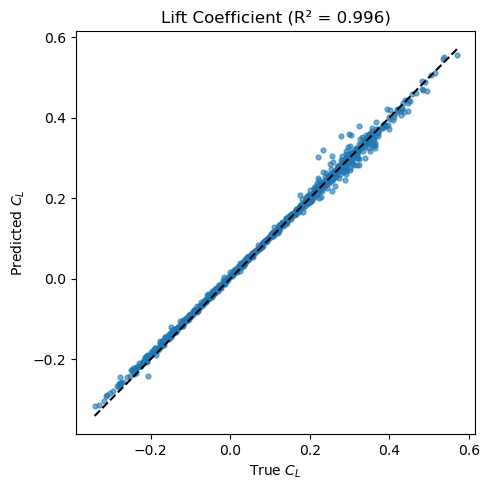

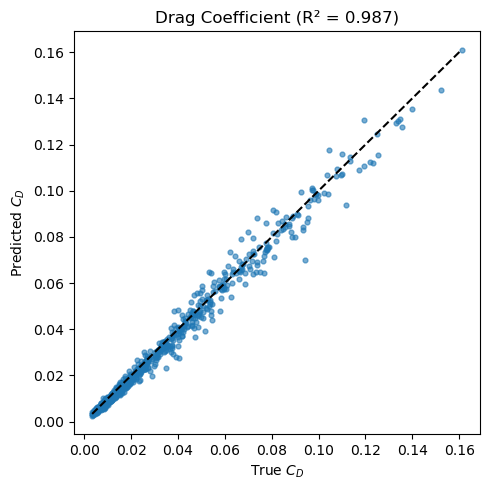

In [2]:
#!/usr/bin/env python3
import pyvista as pv
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

def integrate_from_cmp(vtk_file: Path, tag: str):
    """
    Integrate c_x, c_z from arrays named 
    cp_{tag}, cf_x_{tag}, cf_z_{tag}.
    """
    mesh = pv.read(str(vtk_file))
    cp  = f"cp_{tag}"
    cfx = f"cf_x_{tag}"
    cfz = f"cf_z_{tag}"
    for arr in (cp, cfx, cfz):
        if arr not in mesh.array_names:
            raise RuntimeError(f"'{arr}' missing in {vtk_file.name}")
    n = mesh.point_normals
    mesh["c_x"] = -mesh[cp]  * n[:,0] + mesh[cfx]
    mesh["c_z"] = -mesh[cp]  * n[:,2] + mesh[cfz]
    out = mesh.integrate_data()
    return float(out["c_x"][0]), float(out["c_z"][0])

def main():
    # —— User config —— 
    cmp_dir = Path("./vtk_pred_param")
    meta_csv = "/home/nicksung/Desktop/nicksung/bwb_full/processed/final_data_test.csv"
    # metadata must have columns: case_name, angle_of_attack
    # ————————————

    meta = pd.read_csv(meta_csv)
    records = []

    for case in meta["case_name"]:
        vtk_cmp = cmp_dir / f"{case}_cmp.vtk"
        if not vtk_cmp.exists():
            print(f"  skip {case}, missing {vtk_cmp}")
            continue

        # integrate the ground-truth arrays
        cxt, czt = integrate_from_cmp(vtk_cmp, "ground_truth")
        # integrate your "true-shape" predictions
        cxp, czp = integrate_from_cmp(vtk_cmp, "pred_true")

        # angle of attack to radians
        alpha = np.deg2rad(
            float(meta.loc[meta["case_name"]==case, "alpha_deg"])
        )

        # compute total CL, CD
        CL_t = -cxt*np.sin(alpha) + czt*np.cos(alpha)
        CD_t =  cxt*np.cos(alpha) + czt*np.sin(alpha)
        CL_p = -cxp*np.sin(alpha) + czp*np.cos(alpha)
        CD_p =  cxp*np.cos(alpha) + czp*np.sin(alpha)

        records.append({
            "case":   case,
            "CL_true": CL_t, 
            "CD_true": CD_t,
            "CL_pred": CL_p,
            "CD_pred": CD_p
        })

    df = pd.DataFrame(records)
    if df.empty:
        print("No cases processed!")
        return

    # compute R^2
    r2_CL = r2_score(df["CL_true"], df["CL_pred"])
    r2_CD = r2_score(df["CD_true"], df["CD_pred"])
    print(f"R² (Lift) = {r2_CL:.4f}   R² (Drag) = {r2_CD:.4f}")

    # plot True vs Predicted CL
    plt.figure(figsize=(5,5))
    plt.scatter(df["CL_true"], df["CL_pred"], s=12, alpha=0.6)
    mn, mx = df["CL_true"].min(), df["CL_true"].max()
    plt.plot([mn,mx],[mn,mx],"k--")
    plt.xlabel("True $C_L$")
    plt.ylabel("Predicted $C_L$")
    plt.title(f"Lift Coefficient (R² = {r2_CL:.3f})")
    plt.tight_layout()
    plt.show()

    # plot True vs Predicted CD
    plt.figure(figsize=(5,5))
    plt.scatter(df["CD_true"], df["CD_pred"], s=12, alpha=0.6)
    mn, mx = df["CD_true"].min(), df["CD_true"].max()
    plt.plot([mn,mx],[mn,mx],"k--")
    plt.xlabel("True $C_D$")
    plt.ylabel("Predicted $C_D$")
    plt.title(f"Drag Coefficient (R² = {r2_CD:.3f})")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
